# Risk Premia Portfolio Backtest

In this notebook we backtest a couple of classic long-only risk premia harvesting strategies:

1. Dollar weighted
2. Inverse volatility weighted

We then optimise the trade buffer parameter for out favoured strategy.

Rebalancing in both strategies occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

Capital is re-invested using the square root of profits money manager.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended. Contrast with a percentage commission scheme where trading back to the trade buffer limit is considered optimal.

In [2]:
import sys
import os
from pathlib import PurePath
sys.path.append(str(PurePath(os.getcwd()).parent))

import numpy as np
import pandas as pd

import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    rc={"figure.figsize":(15, 5)},
    style="darkgrid")

import alphasim.backtest as bt
import alphasim.commission as cmn
import alphasim.money as mo
from alphasim.util import like
import alphasim.stats as stats

%matplotlib inline
%reload_ext autoreload
%autoreload 3

In [3]:
benchmark_ticker = "SPY"
benchmark_price_df = yf.download(benchmark_ticker, start="2005-01-01").dropna()['Adj Close']
benchmark_ret_df = benchmark_price_df.div(benchmark_price_df.shift(1)).apply(np.log)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  3 of 3 completed


<AxesSubplot: xlabel='Date'>

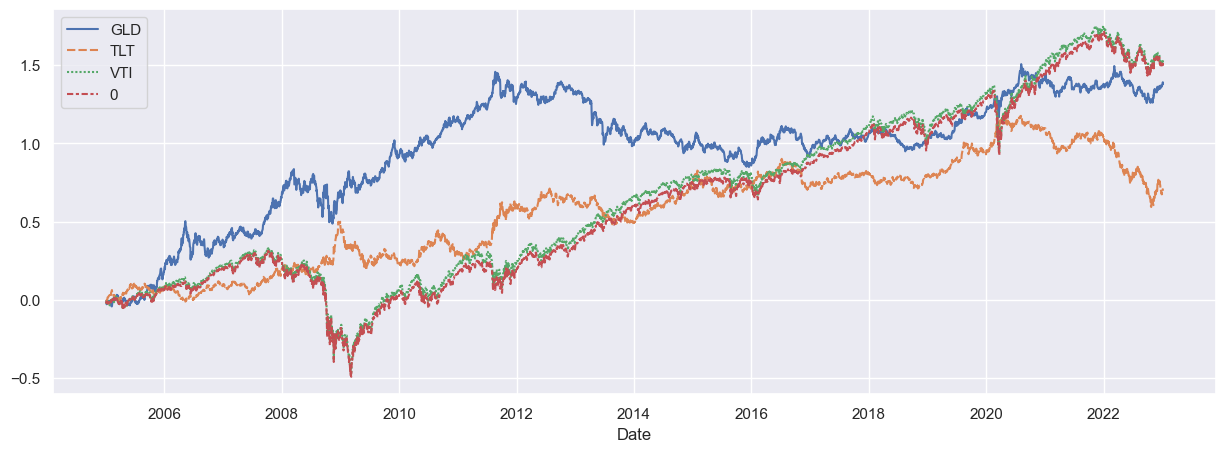

In [4]:
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = yf.download(tickers, start='2005-01-01').dropna()['Adj Close']
logret_df = price_df.div(price_df.shift(1)).apply(np.log)
sns.lineplot(data=pd.concat([logret_df.cumsum(),benchmark_ret_df.cumsum()]))

## Dollar Weights

Define equal dollar weights for our portfolio.

In [5]:
dollar_weight_df = like(price_df)
dollar_weight_df[:] = [0.333, 0.333, 0.333]

## Inverse Volatility Weights

Define weights based on a rolling volatility measure.

In [6]:
def calc_invol_weight(cov_mat):
    vol = np.sqrt(np.diagonal(cov_mat))
    invol = 1 / vol
    wt = invol / np.sum(invol)
    return wt

/var/folders/g8/cr0p80215nbcfxwt3ppj6cvh0000gn/T/ipykernel_58599/1185675981.py:3: RuntimeWarning: divide by zero encountered in divide
  invol = 1 / vol
/var/folders/g8/cr0p80215nbcfxwt3ppj6cvh0000gn/T/ipykernel_58599/1185675981.py:4: RuntimeWarning: invalid value encountered in divide
  wt = invol / np.sum(invol)


<AxesSubplot: xlabel='Date'>

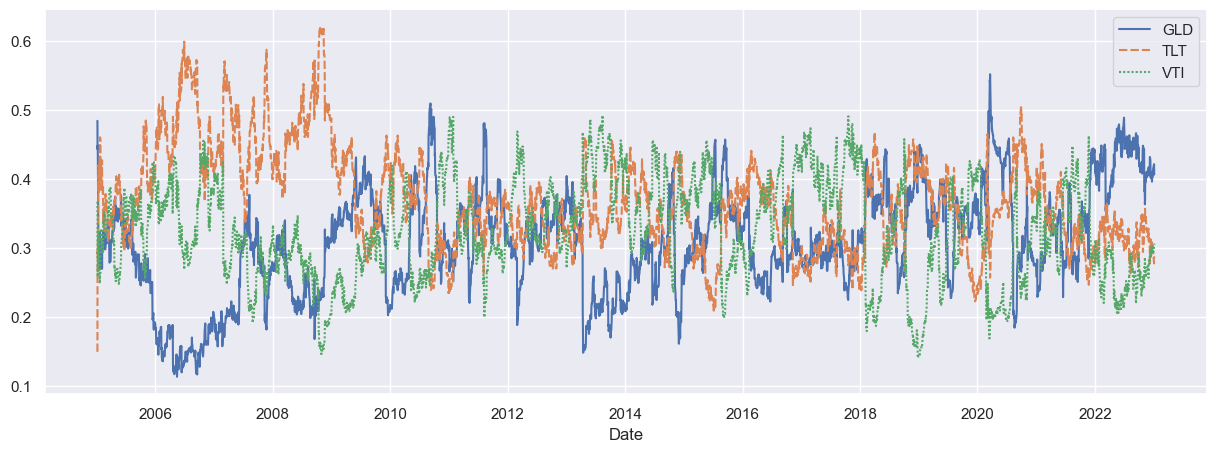

In [7]:
cov_mat = (
    logret_df
    .ewm(alpha=1-0.94)
    .cov()
    .groupby(axis=0, level=0)
    .apply(lambda x: x.fillna(0).values)
)
invol_weight_df = like(logret_df)
invol_weight_df[:] = [calc_invol_weight(x) for x in cov_mat]

sns.lineplot(data=invol_weight_df)

## Backtest

In [8]:
# Define a simple fixed minimum commission scheme whereby every trade costs 10 of the quote currency
def commission(trade_size, trade_value):
    return cmn.fixed_commission(trade_size, trade_value, 10)

In [9]:
# Execute our backtest for the dollar weighted strategy
dw_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=dollar_weight_df.copy(),
    trade_buffer=0.1, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [10]:
# Align the length of prices and weights
price_df = price_df.align(invol_weight_df, axis=0, join='inner')[0]

# Execute our backtest for the ERC strategy
invol_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=invol_weight_df.copy(),
    trade_buffer=0.1, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [11]:
# Compare performance stats
dw_stat_df = stats.backtest_stats(dw_result_df)
invol_stat_df = stats.backtest_stats(invol_result_df)
display(pd.concat([dw_stat_df, invol_stat_df], keys=["dollar_weighted", "invol_weighted"], axis=1))

,dollar_weighted,invol_weighted
,result,result
start,2005-01-03 00:00:00,2005-01-03 00:00:00
end,2023-01-05 00:00:00,2023-01-05 00:00:00
trading_days_year,252,252
initial,10000.0,10000.0
final,29301.544576,27999.905541
profit,19301.544576,17999.905541
cagr,0.042058,0.040245
ann_volatility,0.071599,0.065468
ann_sharpe,0.587403,0.614726


<AxesSubplot: xlabel='Date'>

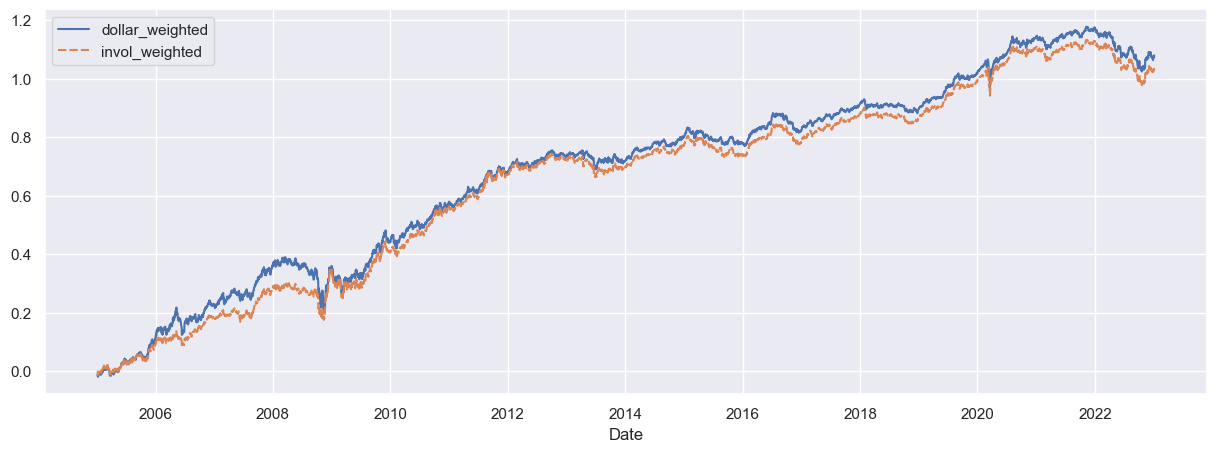

In [12]:
cumsum_df = pd.concat([
    stats.backtest_log_returns(dw_result_df).cumsum(),
    stats.backtest_log_returns(invol_result_df).cumsum()
], keys=["dollar_weighted", "invol_weighted"], axis = 1)

sns.lineplot(data=cumsum_df)

<AxesSubplot: xlabel='Date'>

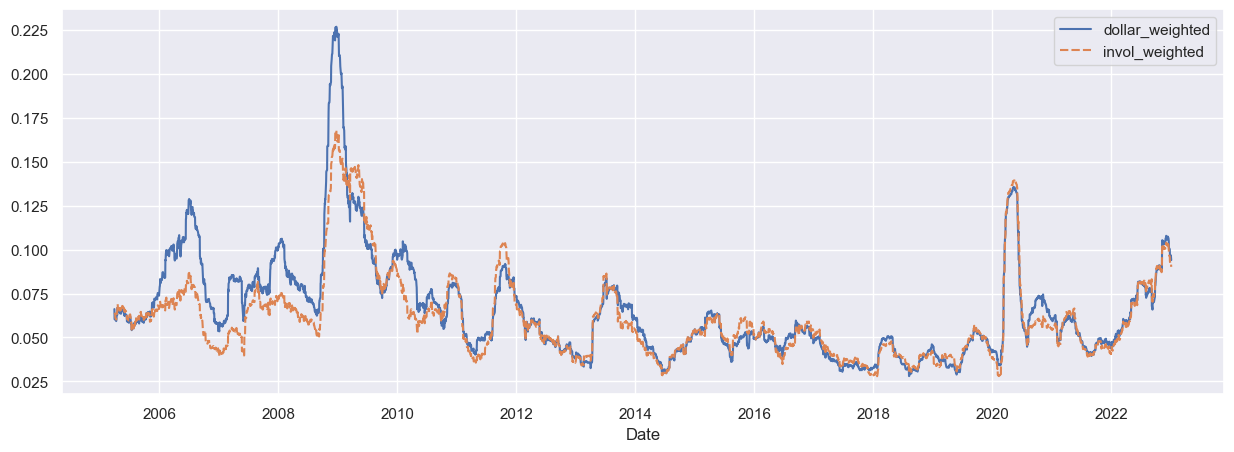

In [13]:
vol_df = pd.concat([
    stats.backtest_log_returns(dw_result_df).rolling(window=60).std() * np.sqrt(252),
    stats.backtest_log_returns(invol_result_df).rolling(window=60).std() * np.sqrt(252),
], keys=["dollar_weighted", "invol_weighted"], axis = 1)

sns.lineplot(data=vol_df)

## Choosing a strategy

Despite the drag on profit from the extra trading costs, the inverse volatility strategy enjoys lower volatility.

In the next step we will optimise the trade buffer to reduce portfolio turnover.

## Optimising trade buffer

Analysing the trade buffer by risk-adjusted returns indicates a buffer of 10% would give optimal returns.

In [14]:
price_df = price_df.align(invol_weight_df, axis=0, join='inner')[0]

trade_buffers = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

sharpes = np.array([])

for tb in trade_buffers:

    df = bt.backtest(
        prices=price_df.copy(), 
        weights=invol_weight_df.copy(),
        trade_buffer=tb, 
        do_trade_to_buffer=False, 
        commission_func=commission,
        initial_capital=10000,
        money_func=mo.sqrt_profit)

    sharpes = np.append(sharpes, [stats.backtest_stats(df).T["ann_sharpe"]])

,trade_buffer,sharpe
0,0.0,-0.807263
1,0.1,0.614726
2,0.2,0.717332
3,0.3,0.608626
4,0.4,0.611509
5,0.5,0.22824


<AxesSubplot: xlabel='trade_buffer', ylabel='sharpe'>

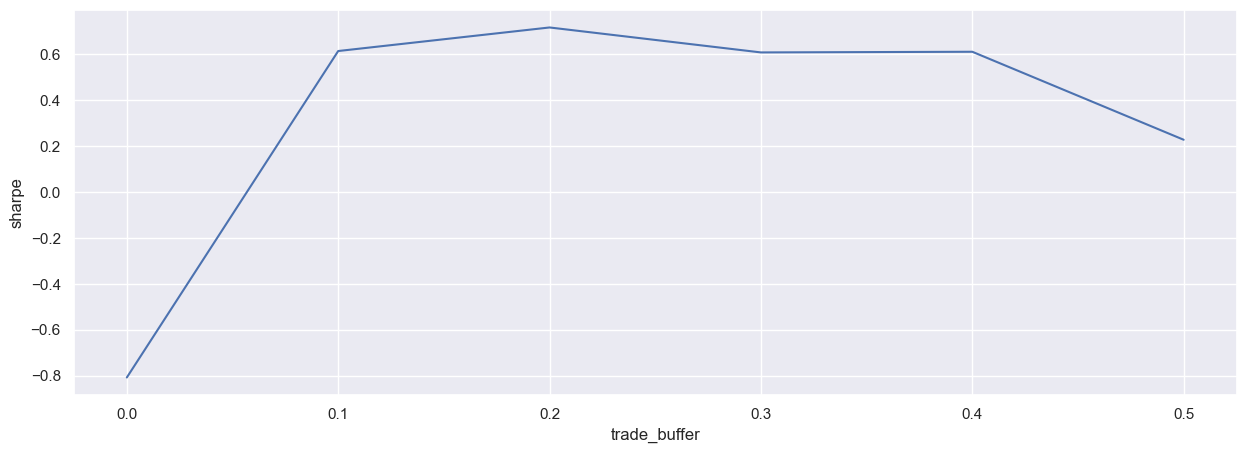

In [15]:
result_df = pd.DataFrame()
result_df["trade_buffer"] = trade_buffers
result_df["sharpe"] = sharpes
display(result_df)

sns.lineplot(data=result_df, x="trade_buffer", y="sharpe")

In [16]:
optima_idx = result_df["sharpe"].astype(np.float64).idxmax()
optima_buffer = result_df["trade_buffer"].iloc[optima_idx]
optima_buffer = float(f"{optima_buffer:.4f}")
display(optima_buffer)

0.2

## Optimising target volatility

In [17]:
def port_vol(weights, cov_mat):
    var = weights.T @ (cov_mat) @ weights
    vola = np.sqrt(var)
    return vola

def vol_target_weight(weights, est_vol, target_vol, max_lev=None):
    if np.isnan(est_vol) or est_vol <= 0:
        return weights
    vola_adj_f = target_vol / est_vol
    if max_lev is not None:
        vola_adj_f = np.clip(vola_adj_f, 0, max_lev)
    adj_weights = weights * vola_adj_f
    return adj_weights

In [18]:
pf_vol_df = pd.Series(index=invol_weight_df.index, dtype=np.float64)
pf_vol_df[:] = [port_vol(x, y) for x, y in zip(invol_weight_df.values, cov_mat)]
pf_vol_df *= np.sqrt(252)

target_vol = 0.12
vol_target_weight_df = like(invol_weight_df)
vol_target_weight_df[:] = [vol_target_weight(x, y, target_vol) for x, y in zip(invol_weight_df.values, pf_vol_df.values)]

<AxesSubplot: xlabel='Date'>

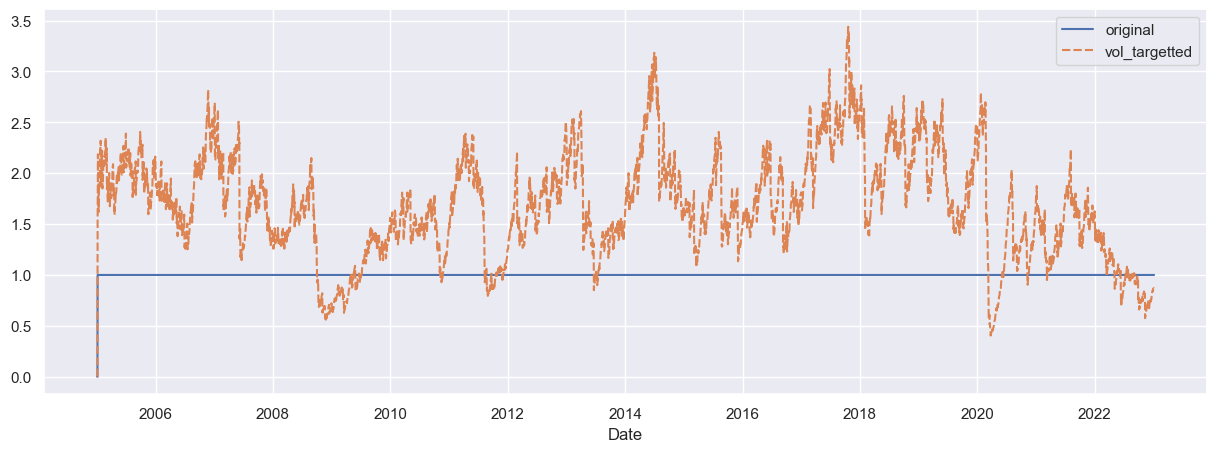

In [19]:
sns.lineplot(data=pd.concat(
    [invol_weight_df.sum(axis=1), vol_target_weight_df.sum(axis=1)], 
    keys=["original", "vol_targetted"], 
    axis=1))

## Final optima backtest

In [20]:
result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=vol_target_weight_df.copy(),
    trade_buffer=optima_buffer, 
    do_trade_to_buffer=False, 
    commission_func=commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

An improved sharpe and CAGR is clear when comparing the optima and original ERC strategy.

In [21]:
optima_stat_df = stats.backtest_stats(result_df, benchmark_price_df.to_frame())
display(pd.concat([optima_stat_df, invol_stat_df], keys=["optima", "original_invol"], axis=1))

optima                       \
                             benchmark             backtest   
start              2005-01-03 00:00:00  2005-01-03 00:00:00   
end                2023-01-05 00:00:00  2023-01-05 00:00:00   
trading_days_year                  252                  252   
initial                        10000.0              10000.0   
final                     44688.479856         41946.232914   
profit                    34688.479856         31946.232914   
cagr                          0.059049             0.056483   
ann_volatility                 0.19599             0.088762   
ann_sharpe                    0.301288             0.636338   
trade_count                        1.0                264.0   
skew                         -0.066089            -0.272736   
kurtosis                     14.655958             2.623751   
commission                         NaN              -2640.0   
funding_payment                    NaN                  0.0   
cost_profit_pct                    NaN            -0.082639   
ann_turnover                       NaN             0.705396   

                        original_invol  
                                result  
start              2005-01-03 00:00:00  
end                2023-01-05 00:00:00  
trading_days_year                  252  
initial                        10000.0  
final                     27999.905541  
profit                    17999.905541  
cagr                          0.040245  
ann_volatility                0.065468  
ann_sharpe                    0.614726  
trade_count                      124.0  
skew                          0.025243  
kurtosis                      4.523413  
commission                     -1240.0  
funding_payment                    0.0  
cost_profit_pct              -0.068889  
ann_turnover                  0.187907

<AxesSubplot: xlabel='Date'>

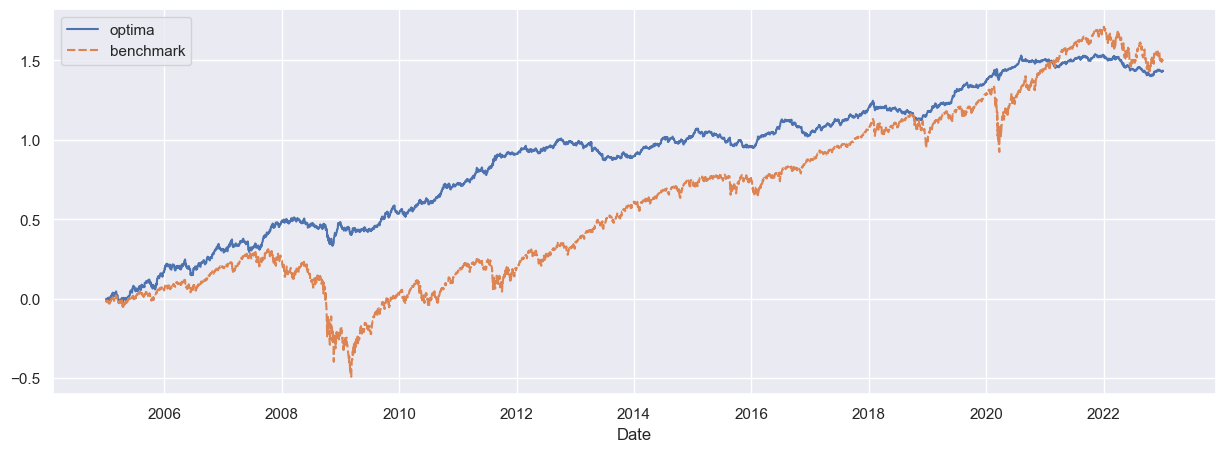

In [22]:
sns.lineplot(data=pd.concat(
    [stats.backtest_log_returns(result_df).cumsum(), benchmark_ret_df.cumsum()], 
    keys=["optima", "benchmark"], 
    axis=1))

<AxesSubplot: xlabel='Date'>

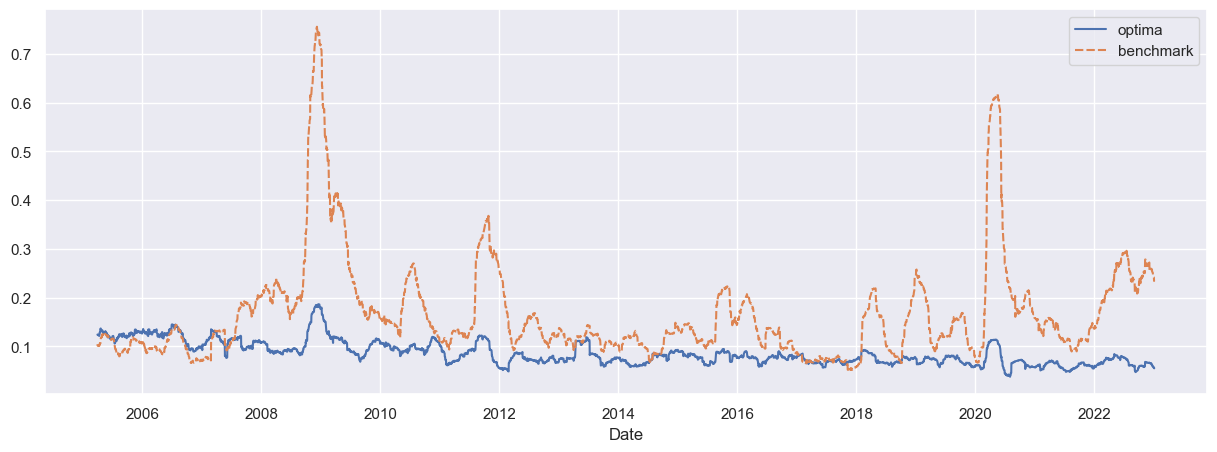

In [23]:
sns.lineplot(data=pd.concat(
    [stats.backtest_log_returns(result_df).rolling(window=60).std() * np.sqrt(252), 
    benchmark_ret_df.rolling(window=60).std() * np.sqrt(252)], 
    keys=["optima", "benchmark"], 
    axis=1))

Note the large rebalances indicated by the right angle change in assets weights. A smaller trade buffer would result in more frequent trades and less abrupt changes in portfolio weights, but at the expense of risk-adjusted returns in this case.

<AxesSubplot: xlabel='Date'>

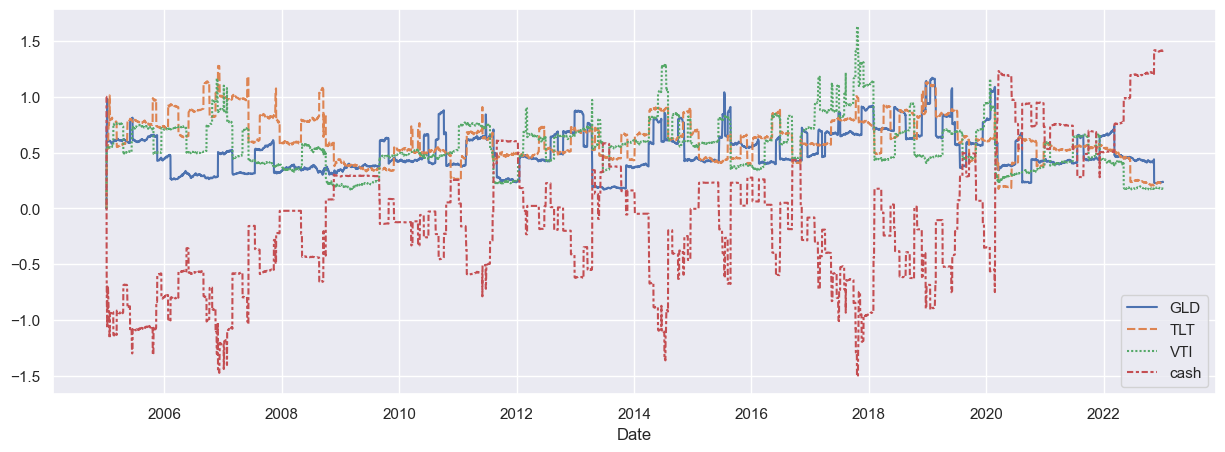

In [24]:
ticker_weight_df = result_df["start_weight"].unstack()
sns.lineplot(data=ticker_weight_df)